<h3>Цель найти ошибки, вида:</h3>

Бот задает вопрос клиенту о готовности предоставить оплату завтра. 
<ul>
<li>Если клиент отвечает отрицательно >>> бот начинает вести себя так, будто был положительный ответ.</li>
<li>Если клиент отвечает положительно >>> бот начинает вести себя так, будто клиент дал отрицательный ответ.</li>
</ul>

In [ ]:
import json
import os
import sys
from typing import List

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import pymorphy2

import gensim
from gensim.utils import tokenize
from gensim.corpora import Dictionary
from gensim.models import LdaModel

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer as tfidf_t


import sklearn
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

In [ ]:
files = os.listdir(ROOT_FOLDER)[:-1]
full_path_files = [os.path.join(ROOT_FOLDER, current_file) for current_file in files]
full_path_files

In [ ]:
df1 = pd.read_excel(full_path_files[0], engine='openpyxl')

In [7]:
def load_dialog(converted_file_content_string: str)-> dict:
    '''
    Конвертация сырой строки в json object
    '''
    json_object = json.loads(converted_file_content_string)
    return json_object


def preprocessing_json_object(json_object: dict)-> List[List[str]]:
    '''
    Конвертация json object в таблицу
    '''
    dialog_table = []
    dialog = json_object['communication']['dialog']
    for current_item in dialog:
        speaker = list(current_item.keys())[0] 
        sent = current_item[speaker]['text']
        dialog_table.append([
            speaker,
            sent
        ])
    return dialog_table


def convert_to_pandas_DataFrame(table: List[List[str]])-> pd.DataFrame:
    '''
    Конвертация в pandas data frame
    '''
    return pd.DataFrame(table, columns=['speaker', 'sent'])

In [9]:
#пока возьмем только 1 таблицу и из нее возьмем 100 000 диалогов
data = []
for index, item in tqdm(enumerate(CONVERTED_FILE_CONTENT[:100000])):
    try:
        data.append(
            convert_to_pandas_DataFrame(
                preprocessing_json_object(load_dialog(item))
            )
        )    
    except:
        pass

100000it [01:22, 1217.20it/s]


Интересуют только те диалоги, в которых робот смог дойди до вопроса *ВЫ ГОТОВЫ ОПЛАТИТЬ ЕЁ ЗАВТРА?*, а если точнее, что ответил клиент после этого вопроса.

Возьмем только те таблицы, в которых робот дошел до стадии вопроса об оплате, далее сохраним все ответы пользователей.

In [56]:
len(data)

99909

In [136]:
#список вопросов об оплате
robot_questions = [
    'ВНЕСЕТЕ ПЛАТЕЖ?'
    'ОПЛАТА ПОСТУПИТ ЗАВТРА?',
    'ВЫ ГОТОВЫ ПРОИЗВЕСТИ ОПЛАТУ ЗАВТРА?',
    'ВЫ ГОТОВЫ ОПЛАТИТЬ ЕЁ ЗАВТРА?',
    'ВЫ ГОТОВЫ ОПЛАТИТЬ ЭТУ СУММУ?',
    'ВО ИЗБЕЖАНИЕ НЕГАТИВНЫХ ПОСЛЕДСТВИЙ, ВЫ ГОТОВЫ ПРОИЗВЕСТИ ОПЛАТУ ЗАВТРА?'
]

#ответы клиентов
client_answers = []

#номера таблиц в которых отсутствует вопрос или их по какой-то причине более 1,
#пока для простоты не будем рассматривать эти случаи. 
black_indexes = []

#идем по каждому диалогу и отбираем только те, в которых бот 1 раз задает вопрос из списка, 
#далее забираем ответы клиента.
for table_index, table in enumerate(data):
    search_robot_questions = table.loc[((table['sent'].isin(robot_questions)) & \
                                        (table['speaker'] == 'robot'))]
    if search_robot_questions.shape[0] == 1:
        try:
            index = search_robot_questions.index[0] + 1
            client_answers.append(table.iloc[index]['sent'])
        except IndexError:
            black_indexes.append(table_index)
    else:
        black_indexes.append(table_index)

In [19]:
pointed_table[100]

,speaker,sent
14,robot,ВЫ ГОТОВЫ ОПЛАТИТЬ ЕЁ ЗАВТРА?
15,customer,НУ ДА КОНЕЧНО
16,customer,АЛЛЁ ДА ДА ДА
17,robot,Я ФИКСИРУЮ ВАШЕ ОБЕЩАНИЕ ОБ ОПЛАТЕ
18,robot,ОДНУ ТЫСЯЧУ ПЯТЬСОТ ДВАДЦАТЬ ПЯТЬ РУБЛЕЙ
19,robot,ДО ПЯТОГО ИЮНЯ
20,robot,ВСЕГО ХОРОШЕГО ДО СВИДАНИЯ


Теперь структурируем ответы клиентов в класстеры. 

In [143]:
import pymorphy2
from gensim.utils import tokenize


MORPH_ANALYZER = pymorphy2.MorphAnalyzer()

#простая предобработка текста(токенизация и приведение к нормальной форме)
def simple_preprocessing(sent):
    return ' '.join([MORPH_ANALYZER.normal_forms(word)[0] for word in tokenize(sent.lower())])

simple_preprocessing('МОЖНО ПАРУ ДНЕЙ ДАЙТЕ МНЕ ЕЩЁ ПОЖАЛУЙСТА Я ПРОСТО С РЕБЁНКОМ ВЫЕХАТЬ НЕ МОГУ')

'можно пара день дать я ещё пожалуйста я просто с ребёнок выехать не мочь'

Векторизация корпуса

In [145]:
#предобработка текста
preproc_data = [simple_preprocessing(item) for item in client_answers]
#векторизация
vectorizer = CountVectorizer()
vectorizer_corpus = vectorizer.fit_transform(preproc_data)
tfidf = tfidf_t()
vectors = tfidf.fit_transform(vectorizer_corpus)

In [148]:
vectors.shape

(30301, 2304)

In [33]:
preproc_data = [simple_preprocessing(item) for item in answers]

In [36]:
vectorizer = CountVectorizer()

In [38]:
vectorizer_corpus = vectorizer.fit_transform(preproc_data)
tfidf = tfidf_t()
vectors = tfidf.fit_transform(vectorizer_corpus)
vectors.shape

(7860, 1139)

In [39]:
sparce_matrix_toarray = vectors.toarray()
sparce_matrix_toarray.shape

(7860, 1139)

In [154]:
vectors

<30301x2304 sparse matrix of type '<class 'numpy.float64'>'
	with 96595 stored elements in Compressed Sparse Row format>

In [155]:
from sklearn.decomposition import PCA
low_vectors = PCA(n_components=2).fit_transform(vectors.toarray())

In [158]:
low_vectors_tsne = TSNE(n_components=2).fit_transform(vectors.toarray())

In [162]:
import seaborn as sns

In [230]:
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN 


low_vectors_tsne = TSNE(n_components=2).fit_transform(vectors.toarray())

result = pd.DataFrame()
result['txt'] = client_answers
result['e1'] = low_vectors_tsne[:, 0]
result['e2'] = low_vectors_tsne[:, 1]
for eps in [0.1, 0.3, 0.5, 0.7, 1]:
    result[f'dbscan_{eps}'] = DBSCAN(eps=eps, min_samples=2).fit(low_vectors_tsne).labels_

In [232]:
result.head(5)

,txt,e1,e2,dbscan_0.1,dbscan_0.3,dbscan_0.5,dbscan_0.7,dbscan_1
0,А Я УЖЕ ЕЁ ОПЛАТИЛ,6.880926,-41.960621,0,0,0,0,0
1,У МЕНЯ НЕТ ЗАДОЛЖЕННОСТИ НИКАКОЙ Я НЕ БРАЛА У ...,-1.592454,3.688030,-1,1,1,1,1
2,ДА,13.273931,16.619316,1,2,2,2,2
3,Я ЕЁ ПЛАЧУ СЕЙЧАС,-18.877615,-33.420395,2,3,3,3,3
4,ДА,13.273931,16.619316,1,2,2,2,2


In [233]:
result[result['dbscan_1'] == 0]

,txt,e1,e2,dbscan_0.1,dbscan_0.3,dbscan_0.5,dbscan_0.7,dbscan_1
0,А Я УЖЕ ЕЁ ОПЛАТИЛ,6.880926,-41.960621,0,0,0,0,0
171,Я УЖЕ ОПЛАТИЛА ЕЁ,6.880838,-41.960743,0,0,0,0,0
341,Я УЖЕ ЕЁ ОПЛАТИЛА,6.880182,-41.961361,0,0,0,0,0
671,Я ЕЁ ОПЛАТИЛА УЖЕ,6.881286,-41.960922,0,0,0,0,0
1333,Я ЕЁ УЖЕ ОПЛАТИЛ,6.881023,-41.960949,0,0,0,0,0
1541,Я УЖЕ ОПЛАТИЛА ЕЁ,6.881513,-41.961159,0,0,0,0,0
2673,А Я УЖЕ ОПЛАТИЛА ЕЁ,6.880231,-41.960484,0,0,0,0,0
2817,Я ЕЁ УЖЕ ОПЛАТИЛА,6.882234,-41.961113,0,0,0,0,0
3788,Я ЕЁ УЖЕ ОПЛАТИЛ,6.880764,-41.960762,0,0,0,0,0
4344,Я ЕЁ УЖЕ ОПЛАТИЛ,6.881264,-41.961010,0,0,0,0,0


In [237]:
result[result['dbscan_1'] == 5]

,txt,e1,e2,dbscan_0.1,dbscan_0.3,dbscan_0.5,dbscan_0.7,dbscan_1
7,ЗАВТРА НЕТ В ТЕЧЕНИЕ ТРЁХ ДНЕЙ,-20.468359,44.678768,4,5,5,5,5
235,НУ В ТЕЧЕНИЕ ТРЁХ ДНЕЙ,-22.227507,45.693829,120,144,133,5,5
372,В ТЕЧЕНИЕ ТРЁХ ДНЕЙ,-22.197268,43.944065,169,202,186,5,5
427,В ТЕЧЕНИЕ ТРЁХ ДНЕЙ,-22.197378,43.944256,169,202,186,5,5
466,НЕТ ЕЩЁ ТРИ ДНЯ ЕСЛИ МОЖНО,-23.079481,41.626068,-1,238,220,211,5
...,...,...,...,...,...,...,...,...
28885,ДА Я МОЖЕТ СЕГОДНЯ ЗА НУ ДВА ТРИ ДНЯ Я ОПЛАЧУ,-23.477680,46.542557,-1,2825,239,5,5
28982,НЕТ В ТЕЧЕНИЕ ТРЁХ ДНЕЙ,-20.890791,44.779636,1908,1894,5,5,5
29128,В ТЕЧЕНИЕ ДВУХ ДНЕЙ,-25.288359,46.533604,287,349,309,5,5
30008,НЕТ В ТЕЧЕНИЕ ТРЁХ ДНЕЙ,-20.890642,44.779572,1908,1894,5,5,5


<AxesSubplot:xlabel='e1', ylabel='e2'>

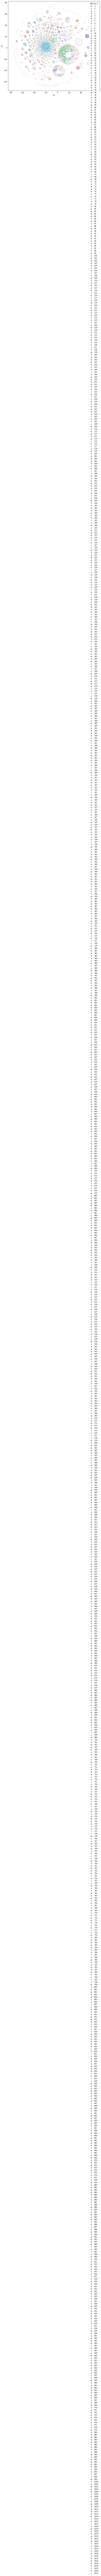

In [228]:
%matplotlib inline
plt.figure(figsize=(10, 10))
sns.scatterplot(data=result, x='e1', y='e2',
                palette='deep', hue='dbscan_1', s=5)

In [222]:
result[result['dbscan_03'] == 4]

,txt,e1,e2,dbscan_01,dbscan_03,dbscan_05,dbscan_07,dbscan_1
9,НЕТ,27.455881,17.362808,4,4,4,0,0
27,НЕТ,27.455881,17.362808,4,4,4,0,0
38,НЕТ НЕТ НЕТ НЕТ,24.545958,19.883076,4,4,4,0,0
46,НЕТ,24.545958,19.883076,4,4,4,0,0
48,НЕТ,27.455881,17.362808,4,4,4,0,0
...,...,...,...,...,...,...,...,...
30267,НЕТ,27.455881,17.362808,4,4,4,0,0
30274,НЕТ,27.455881,17.362808,4,4,4,0,0
30281,НЕТ,27.455881,17.362808,4,4,4,0,0
30291,НЕТ,27.455881,17.362808,4,4,4,0,0


In [229]:
result[result['dbscan_03'] == 0]

,txt,e1,e2,dbscan_01,dbscan_03,dbscan_05,dbscan_07,dbscan_1
0,А Я УЖЕ ЕЁ ОПЛАТИЛ,-9.752893,54.610374,0,0,0,0,0
171,Я УЖЕ ОПЛАТИЛА ЕЁ,-9.752805,54.610523,0,0,0,0,0
341,Я УЖЕ ЕЁ ОПЛАТИЛА,-9.752857,54.609367,0,0,0,0,0
671,Я ЕЁ ОПЛАТИЛА УЖЕ,-9.752545,54.610649,0,0,0,0,0
1333,Я ЕЁ УЖЕ ОПЛАТИЛ,-9.752573,54.610569,0,0,0,0,0
1541,Я УЖЕ ОПЛАТИЛА ЕЁ,-9.752327,54.610794,0,0,0,0,0
2673,А Я УЖЕ ОПЛАТИЛА ЕЁ,-9.753282,54.610088,0,0,0,0,0
2817,Я ЕЁ УЖЕ ОПЛАТИЛА,-9.751629,54.610962,0,0,0,0,0
3788,Я ЕЁ УЖЕ ОПЛАТИЛ,-9.752833,54.610466,0,0,0,0,0
4344,Я ЕЁ УЖЕ ОПЛАТИЛ,-9.752493,54.610558,0,0,0,0,0


<AxesSubplot:xlabel='e1', ylabel='e2'>

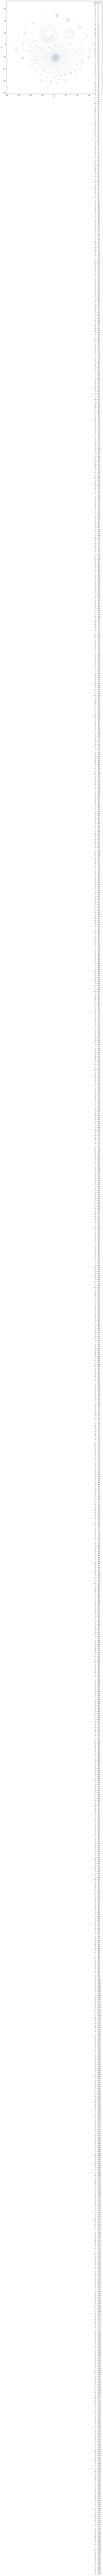

In [203]:
%matplotlib inline
plt.figure(figsize=(13, 13))
sns.scatterplot(data=result, x='e1', y='e2', palette='deep', hue='dbscan_01', s=5)

In [193]:
result[result['dbscan_03'] == 5]

,txt,e1,e2,dbscan_01,dbscan_03,dbscan_05,dbscan_07,dbscan_1
10,СЕГОДНЯ ГОТОВО,12.352666,34.803112,5,5,1,0,0
940,СЕГОДНЯ ГОТОВО,12.352666,34.803112,5,5,1,0,0
1931,СЕГОДНЯ ГОТОВО,12.352624,34.803112,5,5,1,0,0
2389,СЕГОДНЯ ГОТОВЫ,12.352181,34.802029,5,5,1,0,0
2613,СЕГОДНЯ ГОТОВ,12.352157,34.801987,5,5,1,0,0
2631,СЕГОДНЯ ГОТОВЫ,12.352168,34.802082,5,5,1,0,0
2841,Я ГОТОВА И СЕГОДНЯ,12.352679,34.803082,5,5,1,0,0
3930,И СЕГОДНЯ Я ГОТОВ,12.352207,34.802223,5,5,1,0,0
6309,СЕГОДНЯ ГОТОВ,12.352165,34.802017,5,5,1,0,0
7509,ГОТОВ СЕГОДНЯ,12.352602,34.803028,5,5,1,0,0


In [241]:
result[result['dbscan_0.1'] == 0]

,txt,e1,e2,dbscan_0.1,dbscan_0.3,dbscan_0.5,dbscan_0.7,dbscan_1
0,А Я УЖЕ ЕЁ ОПЛАТИЛ,6.880926,-41.960621,0,0,0,0,0
171,Я УЖЕ ОПЛАТИЛА ЕЁ,6.880838,-41.960743,0,0,0,0,0
341,Я УЖЕ ЕЁ ОПЛАТИЛА,6.880182,-41.961361,0,0,0,0,0
671,Я ЕЁ ОПЛАТИЛА УЖЕ,6.881286,-41.960922,0,0,0,0,0
1333,Я ЕЁ УЖЕ ОПЛАТИЛ,6.881023,-41.960949,0,0,0,0,0
1541,Я УЖЕ ОПЛАТИЛА ЕЁ,6.881513,-41.961159,0,0,0,0,0
2673,А Я УЖЕ ОПЛАТИЛА ЕЁ,6.880231,-41.960484,0,0,0,0,0
2817,Я ЕЁ УЖЕ ОПЛАТИЛА,6.882234,-41.961113,0,0,0,0,0
3788,Я ЕЁ УЖЕ ОПЛАТИЛ,6.880764,-41.960762,0,0,0,0,0
4344,Я ЕЁ УЖЕ ОПЛАТИЛ,6.881264,-41.961010,0,0,0,0,0


In [394]:
candidate = []
for dialog in negative_answer['TABLE'].to_list():
    if dialog[dialog['sent'] == 'Я ФИКСИРУЮ ВАШЕ ОБЕЩАНИЕ ОБ ОПЛАТЕ'].shape[0] > 0:
        candidate.append(dialog)

In [413]:
len(candidate)

419